In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import seaborn as sns

In [2]:
order_data = pd.read_csv('Data\olist_orders_dataset.csv')
order_payment_data = pd.read_csv('Data\olist_order_payments_dataset.csv')
order_item_data = pd.read_csv('Data\olist_order_items_dataset.csv')
products_data = pd.read_csv('Data\olist_products_dataset.csv')
order_reviews_data = pd.read_csv('Data\olist_order_reviews_dataset.csv')
customer_data = pd.read_csv('Data\olist_customers_dataset.csv')
seller_data = pd.read_csv('Data\olist_sellers_dataset.csv')
geo_data = pd.read_csv('Data\olist_geolocation_dataset.csv')

translation_data = pd.read_csv('Data\product_category_name_translation.csv')

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Machiavelli127\AppData\Local\Temp\ipykernel_20024\1031020909.py:1: SyntaxWarning: invalid

## Tính khoảng cách giữa seller và customer

In [3]:

# Kết hợp dữ liệu từ các bảng
data_for_distance = order_data[['customer_id', 'order_id']].merge(customer_data[['customer_id', 'customer_zip_code_prefix']], on='customer_id')\
                                                            .merge(order_item_data[['order_id', 'seller_id']], on='order_id')\
                                                            .merge(seller_data[['seller_id', 'seller_zip_code_prefix']], left_on='seller_id', right_on='seller_id') 

data_for_distance = data_for_distance.drop(columns=['order_id', 'seller_id'])

data_for_distance.head()

,customer_id,customer_zip_code_prefix,seller_zip_code_prefix
0,9ef432eb6251297304e76186b10a928d,3149,9350
1,b0830fb4747a6c6d20dea0b8c802d7ef,47813,31570
2,41ce2a54c0b03bf3443c3d931a367089,75265,14840
3,f88197465ea7920adcdbec7375364d82,59296,31842
4,8ab97904e6daea8866dbdbc4fb7aad2c,9195,8752


In [4]:
# Vì giá trị id quá dài nên cần phải rút ngắn để phân tích. Với việc lấy 8 ký tự cuối cùng, tính unique được bảo tồn
len(data_for_distance['customer_id'].unique())

98666

In [5]:
len(data_for_distance['customer_id'].str[-8:].unique())

98666

In [6]:
data_for_distance['customer_id']=data_for_distance['customer_id'].str[-8:]
data_for_distance.head()

,customer_id,customer_zip_code_prefix,seller_zip_code_prefix
0,b10a928d,3149,9350
1,c802d7ef,47813,31570
2,1a367089,75265,14840
3,75364d82,59296,31842
4,fb7aad2c,9195,8752


In [7]:
# Gộp customer với lat, lng
customer_geo = data_for_distance.merge(geo_data[['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']], left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
customer_geo.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'}, inplace=True)
customer_geo = customer_geo.drop(columns=['geolocation_zip_code_prefix', 'seller_zip_code_prefix'])

# Gộp seller với lat, lng
seller_geo = data_for_distance.merge(geo_data[['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']], left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
seller_geo.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'}, inplace=True)
seller_geo = seller_geo.drop(columns=['geolocation_zip_code_prefix', 'customer_zip_code_prefix'])

#final_data = customer_geo.merge(seller_geo, on=['customer_id'])
# Loại bỏ các hàng trùng lặp dựa trên cột 'seller_id'
seller_geo = seller_geo.drop_duplicates(subset='customer_id')
customer_geo = customer_geo.drop_duplicates(subset='customer_id')

In [8]:
distance_customer_seller = customer_geo.merge(seller_geo, on=['customer_id'])

distance_customer_seller.head()

,customer_id,customer_zip_code_prefix,customer_lat,customer_lng,seller_zip_code_prefix,seller_lat,seller_lng
0,b10a928d,3149,-23.574809,-46.587471,9350,-23.680114,-46.452454
1,c802d7ef,47813,-12.169860,-44.988369,31570,-19.810119,-43.984727
2,1a367089,75265,-16.746337,-48.514624,14840,-21.362358,-48.232976
3,75364d82,59296,-5.767733,-35.275467,31842,-19.840168,-43.923299
4,fb7aad2c,9195,-23.675037,-46.524784,8752,-23.551707,-46.260979


In [9]:
# Hàm để tính khoảng cách giữa hai điểm dựa trên vĩ độ và kinh độ
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])

    dlng = lng2 - lng1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# Tính khoảng cách giữa customer và seller
distance_customer_seller['distance_km'] = haversine(distance_customer_seller['customer_lat'], distance_customer_seller['customer_lng'], 
                                   distance_customer_seller['seller_lat'], distance_customer_seller['seller_lng'])
distance_customer_seller.head()

,customer_id,customer_zip_code_prefix,customer_lat,customer_lng,seller_zip_code_prefix,seller_lat,seller_lng,distance_km
0,b10a928d,3149,-23.574809,-46.587471,9350,-23.680114,-46.452454,18.052496
1,c802d7ef,47813,-12.169860,-44.988369,31570,-19.810119,-43.984727,855.754960
2,1a367089,75265,-16.746337,-48.514624,14840,-21.362358,-48.232976,513.807539
3,75364d82,59296,-5.767733,-35.275467,31842,-19.840168,-43.923299,1821.655930
4,fb7aad2c,9195,-23.675037,-46.524784,8752,-23.551707,-46.260979,30.155092


## Scatter plot giữa khoảng cách và thời gian giao hàng

In [10]:
order_data = order_data

In [11]:
order_data['delivered_carrier_time']=pd.to_datetime(order_data['order_delivered_carrier_date'])

order_data['delivered_time'] = pd.to_datetime(order_data['order_delivered_customer_date'])

In [12]:
# Tính toán số ngày giao hàng
order_data['delivery_time_day'] = (order_data['delivered_time'] - order_data['delivered_carrier_time']).dt.days

distance_with_delivery = order_data[['customer_id', 'delivery_time_day']]
distance_with_delivery.head()

,customer_id,delivery_time_day
0,9ef432eb6251297304e76186b10a928d,6.0
1,b0830fb4747a6c6d20dea0b8c802d7ef,12.0
2,41ce2a54c0b03bf3443c3d931a367089,9.0
3,f88197465ea7920adcdbec7375364d82,9.0
4,8ab97904e6daea8866dbdbc4fb7aad2c,1.0


In [13]:
# Rút gọn ID
distance_with_delivery['customer_id']=distance_with_delivery['customer_id'].str[-8:]

C:\Users\Machiavelli127\AppData\Local\Temp\ipykernel_20024\3773866328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_with_delivery['customer_id']=distance_with_delivery['customer_id'].str[-8:]


In [14]:
# Merge dữ liệu với distance_customer_seller
distance_with_delivery = distance_with_delivery.merge(distance_customer_seller[['customer_id', 'distance_km']], on='customer_id')

distance_with_delivery.head()

,customer_id,delivery_time_day,distance_km
0,b10a928d,6.0,18.052496
1,c802d7ef,12.0,855.754960
2,1a367089,9.0,513.807539
3,75364d82,9.0,1821.655930
4,fb7aad2c,1.0,30.155092


In [15]:
# Lọc dữ liệu
filtered_data =distance_with_delivery[(distance_with_delivery['distance_km'] < 4000)]

filtered_data.head()

,customer_id,delivery_time_day,distance_km
0,b10a928d,6.0,18.052496
1,c802d7ef,12.0,855.754960
2,1a367089,9.0,513.807539
3,75364d82,9.0,1821.655930
4,fb7aad2c,1.0,30.155092


C:\Users\Machiavelli127\AppData\Local\Temp\ipykernel_20024\429779774.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='delivery_time_day', y='distance_km', data=filtered_data, palette='sky', legend='full', alpha=0.8, edgecolor='w', s=80)


Text(0.5, 1.0, 'Delivery Time vs Distance')

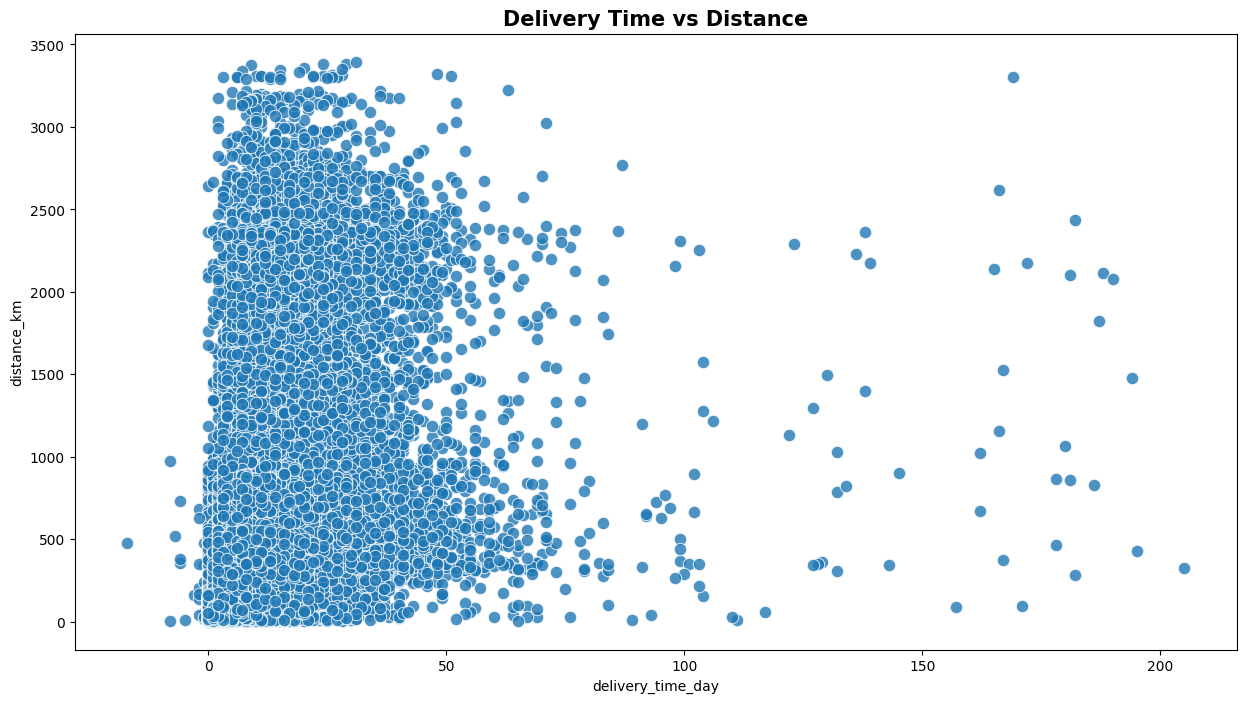

In [38]:

# Scatter plot giữa khoảng cách và thời gian giao hàng
plt.figure(figsize=(15,8))

sns.scatterplot(x='delivery_time_day', y='distance_km', data=filtered_data, palette='viridis', legend='full', alpha=0.8, edgecolor='w', s=80)

plt.title('Delivery Time vs Distance', fontsize=15, weight='bold')

## Correlation Matrix
delivery_time_day, price, freight_value, distance_km, payment_value, product_weight_g, review_score, diff_days (chênh lệch giữa ngày giao hàng thực tế và ước tính), payment_value

In [17]:
order_data['estimate_time']=pd.to_datetime(order_data['order_estimated_delivery_date'])

In [18]:
order_data['diff_days']= (abs(order_data['delivered_time']-order_data['estimate_time'])).dt.days
order_data['diff_days']

0         7.0
1         5.0
2        17.0
3        12.0
4         9.0
         ... 
99436    10.0
99437     1.0
99438     5.0
99439    20.0
99440    17.0
Name: diff_days, Length: 99441, dtype: float64

In [19]:
order_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_carrier_time,delivered_time,delivery_time_day,estimate_time,diff_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-04 19:55:00,2017-10-10 21:25:13,6.0,2017-10-18,7.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-26 14:31:00,2018-08-07 15:27:45,12.0,2018-08-13,5.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08 13:50:00,2018-08-17 18:06:29,9.0,2018-09-04,17.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-22 13:39:59,2017-12-02 00:28:42,9.0,2017-12-15,12.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-14 19:46:34,2018-02-16 18:17:02,1.0,2018-02-26,9.0


In [20]:
corr_matrix = order_data[['order_id','customer_id', 'diff_days', 'delivery_time_day']]
#corr_matrix['order_id']=corr_matrix['order_id'].str[-8:]
corr_matrix.head()

,order_id,customer_id,diff_days,delivery_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7.0,6.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,5.0,12.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,17.0,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,12.0,9.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,9.0,1.0


In [21]:
corr_matrix = pd.merge(corr_matrix, order_item_data[['order_id', 'price', 'freight_value', 'product_id']], on='order_id')

corr_matrix = pd.merge(corr_matrix, order_reviews_data[['order_id', 'review_score']], on='order_id')

corr_matrix = pd.merge(corr_matrix, order_payment_data[['order_id', 'payment_value']], on='order_id')

corr_matrix.head()

,order_id,customer_id,diff_days,delivery_time_day,price,freight_value,product_id,review_score,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7.0,6.0,29.99,8.72,87285b34884572647811a353c7ac498a,4,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7.0,6.0,29.99,8.72,87285b34884572647811a353c7ac498a,4,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7.0,6.0,29.99,8.72,87285b34884572647811a353c7ac498a,4,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,5.0,12.0,118.70,22.76,595fac2a385ac33a80bd5114aec74eb8,4,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,17.0,9.0,159.90,19.22,aa4383b373c6aca5d8797843e5594415,5,179.12


In [22]:
corr_matrix = pd.merge(corr_matrix, products_data[['product_id', 'product_weight_g']], on='product_id')

corr_matrix['customer_id']=corr_matrix['customer_id'].str[-8:]
corr_matrix = pd.merge(corr_matrix, distance_customer_seller[['customer_id', 'distance_km']], on='customer_id')

corr_matrix.head()

,order_id,customer_id,diff_days,delivery_time_day,price,freight_value,product_id,review_score,payment_value,product_weight_g,distance_km
0,e481f51cbdc54678b7cc49136f2d6af7,b10a928d,7.0,6.0,29.99,8.72,87285b34884572647811a353c7ac498a,4,18.12,500.0,18.052496
1,e481f51cbdc54678b7cc49136f2d6af7,b10a928d,7.0,6.0,29.99,8.72,87285b34884572647811a353c7ac498a,4,2.00,500.0,18.052496
2,e481f51cbdc54678b7cc49136f2d6af7,b10a928d,7.0,6.0,29.99,8.72,87285b34884572647811a353c7ac498a,4,18.59,500.0,18.052496
3,53cdb2fc8bc7dce0b6741e2150273451,c802d7ef,5.0,12.0,118.70,22.76,595fac2a385ac33a80bd5114aec74eb8,4,141.46,400.0,855.754960
4,47770eb9100c2d0c44946d9cf07ec65d,1a367089,17.0,9.0,159.90,19.22,aa4383b373c6aca5d8797843e5594415,5,179.12,420.0,513.807539


In [23]:
corr_matrix = corr_matrix.drop(columns=['order_id', 'product_id', 'customer_id'])
corr_matrix.head()

,diff_days,delivery_time_day,price,freight_value,review_score,payment_value,product_weight_g,distance_km
0,7.0,6.0,29.99,8.72,4,18.12,500.0,18.052496
1,7.0,6.0,29.99,8.72,4,2.00,500.0,18.052496
2,7.0,6.0,29.99,8.72,4,18.59,500.0,18.052496
3,5.0,12.0,118.70,22.76,4,141.46,400.0,855.754960
4,17.0,9.0,159.90,19.22,5,179.12,420.0,513.807539


In [24]:
# Get descriptive statistics
desc_stats = corr_matrix.describe()

# Get median
medians = corr_matrix.median()

# Create a new DataFrame with required columns
stats_table = pd.DataFrame({
    'std': desc_stats.loc['std'],
    'mean': desc_stats.loc['mean'],
    'median': medians,
    'min': desc_stats.loc['min'],
    'max': desc_stats.loc['max']
})

stats_table

,std,mean,median,min,max
diff_days,8.185362,12.503840,12.000000,0.00,188.00000
delivery_time_day,8.542522,8.711537,7.000000,-17.00,205.00000
price,182.944843,120.524349,74.900000,0.85,6735.00000
freight_value,15.828077,20.027514,16.280000,0.00,409.68000
review_score,1.387927,4.031467,5.000000,1.00,5.00000
payment_value,265.388194,172.062565,108.100000,0.00,13664.08000
product_weight_g,3785.128931,2110.763062,700.000000,0.00,40425.00000
distance_km,589.758470,596.134683,431.226812,0.00,8731.46217


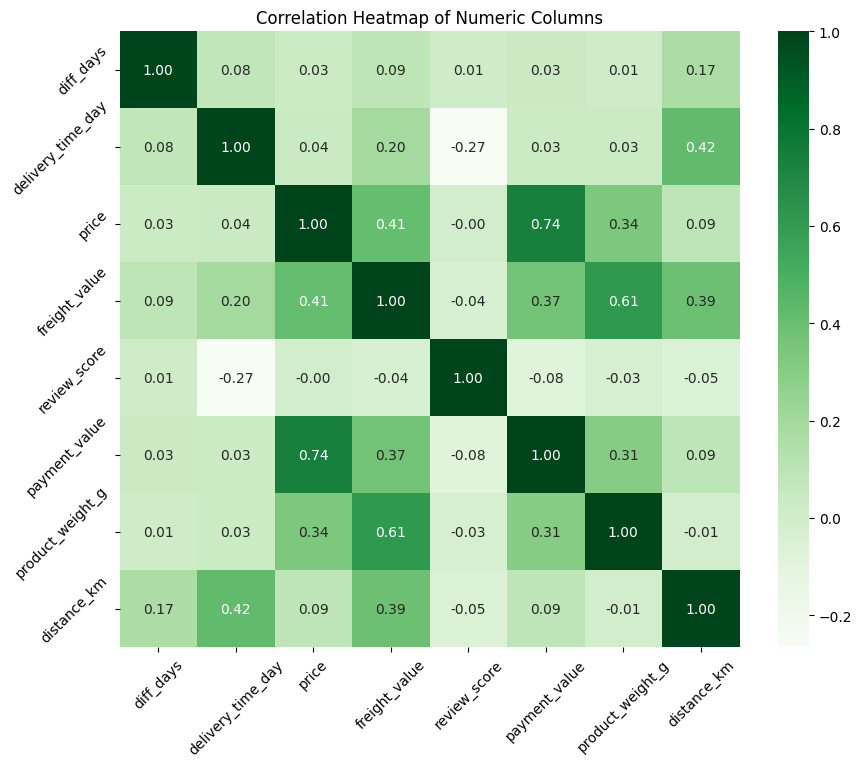

In [25]:
## Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Columns')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## Ảnh hưởng của thời gian vận chuyển đến đánh giá của khách hàng

In [26]:
order_data['difference_days']= (order_data['delivered_time']-order_data['estimate_time']).dt.days
order_data['difference_days']

0        -8.0
1        -6.0
2       -18.0
3       -13.0
4       -10.0
         ... 
99436   -11.0
99437    -2.0
99438    -6.0
99439   -21.0
99440   -18.0
Name: difference_days, Length: 99441, dtype: float64

In [27]:
order_data['delivery_status'] = np.where(order_data['difference_days'] < 0, 'on-time/early', 'late')

delivery_with_review = order_data.merge(order_reviews_data[['order_id', 'review_score']], on='order_id')

delivery_with_review = delivery_with_review[['order_id', 'delivery_status', 'review_score']].sort_values(by='review_score', ascending=True)
delivery_with_review.head()

,order_id,delivery_status,review_score
75302,7feb7cbdc5d53729f835a1ae49f543b6,on-time/early,1
43860,761d2a6c3fc081b13c3cbfa01c4a8c37,late,1
13789,d2709c18f4c1ab5ff4663b1e5a2ea477,on-time/early,1
13793,b6de63fa8c62aeba6eb781539030a825,late,1
43876,d5ebe551f4b4510212d9987245ca489e,on-time/early,1


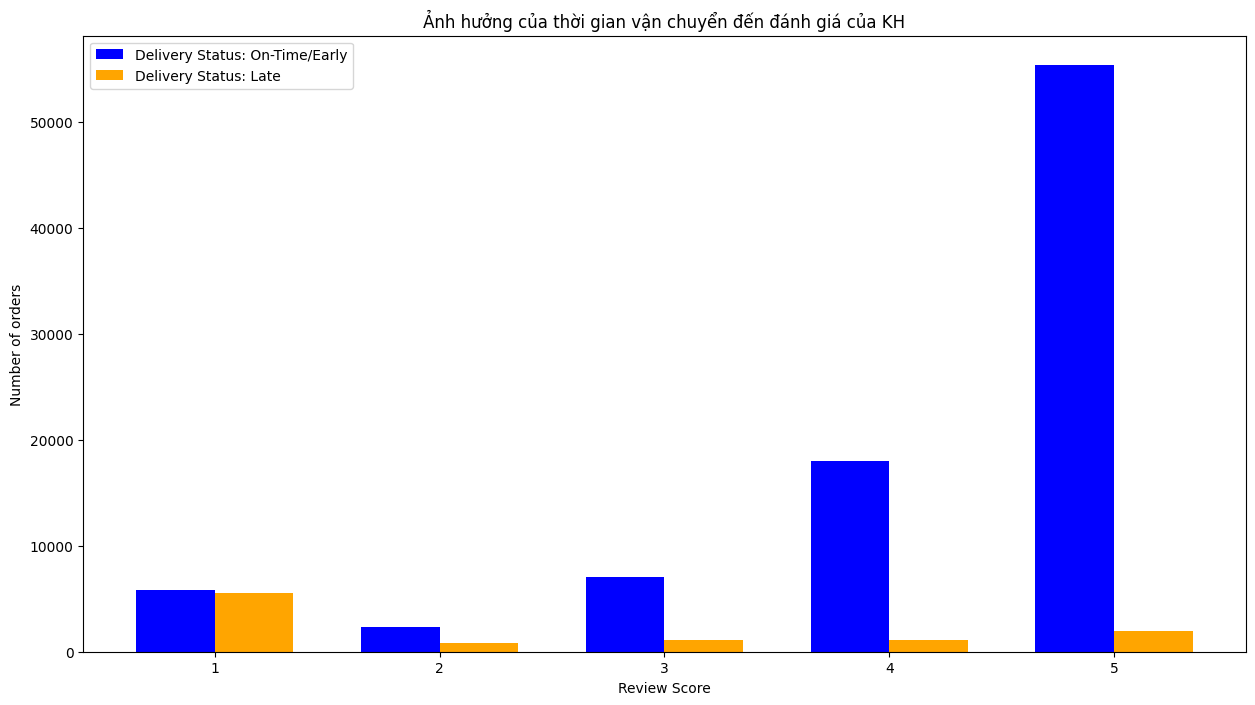

In [28]:
review_scores = delivery_with_review['review_score'].unique()
on_time_early = delivery_with_review[delivery_with_review['delivery_status'] == 'on-time/early']['review_score'].value_counts().sort_index().values
late = delivery_with_review[delivery_with_review['delivery_status'] == 'late']['review_score'].value_counts().sort_index().values

fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.35
index = range(len(review_scores))

rects1 = ax.bar(index, on_time_early, bar_width, color='b', label='Delivery Status: On-Time/Early')
rects2 = ax.bar([i + bar_width for i in index], late, bar_width, color='orange', label='Delivery Status: Late')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Review Score')
ax.set_ylabel('Number of orders')
ax.set_title('Ảnh hưởng của thời gian vận chuyển đến đánh giá của KH')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(review_scores)
ax.legend()

# Hiển thị đồ thị
plt.show()

In [29]:
# Export distance_customer_seller
distance_customer_seller.to_csv('Data\distance_customer_seller.csv', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Machiavelli127\AppData\Local\Temp\ipykernel_20024\1600651166.py:2: SyntaxWarning: invalid escape sequence '\d'
  distance_customer_seller.to_csv('Data\distance_customer_seller.csv', index=False)


In [30]:
distance = distance_customer_seller[['customer_id', 'distance_km']]

In [31]:
distance.head()

,customer_id,distance_km
0,b10a928d,18.052496
1,c802d7ef,855.754960
2,1a367089,513.807539
3,75364d82,1821.655930
4,fb7aad2c,30.155092


In [32]:
order_data['customer_id_split'] = order_data['customer_id'].str[-8:]
order_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_carrier_time,delivered_time,delivery_time_day,estimate_time,diff_days,difference_days,delivery_status,customer_id_split
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-04 19:55:00,2017-10-10 21:25:13,6.0,2017-10-18,7.0,-8.0,on-time/early,b10a928d
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-26 14:31:00,2018-08-07 15:27:45,12.0,2018-08-13,5.0,-6.0,on-time/early,c802d7ef
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08 13:50:00,2018-08-17 18:06:29,9.0,2018-09-04,17.0,-18.0,on-time/early,1a367089
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-22 13:39:59,2017-12-02 00:28:42,9.0,2017-12-15,12.0,-13.0,on-time/early,75364d82
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-14 19:46:34,2018-02-16 18:17:02,1.0,2018-02-26,9.0,-10.0,on-time/early,fb7aad2c


In [33]:
#rename 
distance.rename(columns={'customer_id': 'customer_id_split'}, inplace=True)

order_data = pd.merge(order_data, distance, on='customer_id_split')

C:\Users\Machiavelli127\AppData\Local\Temp\ipykernel_20024\2749823848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance.rename(columns={'customer_id': 'customer_id_split'}, inplace=True)


In [34]:
order_data.drop(columns=['customer_id_split'], inplace=True)

In [35]:
order_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_carrier_time,delivered_time,delivery_time_day,estimate_time,diff_days,difference_days,delivery_status,distance_km
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-04 19:55:00,2017-10-10 21:25:13,6.0,2017-10-18,7.0,-8.0,on-time/early,18.052496
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-26 14:31:00,2018-08-07 15:27:45,12.0,2018-08-13,5.0,-6.0,on-time/early,855.754960
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08 13:50:00,2018-08-17 18:06:29,9.0,2018-09-04,17.0,-18.0,on-time/early,513.807539
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-22 13:39:59,2017-12-02 00:28:42,9.0,2017-12-15,12.0,-13.0,on-time/early,1821.655930
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-14 19:46:34,2018-02-16 18:17:02,1.0,2018-02-26,9.0,-10.0,on-time/early,30.155092


In [36]:
#export to csv
#order_data.to_csv('Data\order_data_with_distance.csv', index=False)

In [ ]:
# based on the schema, we merge the products dataset with the items dataset
items_product = data['items'].merge(data['products'], on= 'product_id', how= 'inner')
orders_ip = data['orders'].merge(items_product, on='order_id', how='inner')

# pivot table aggregating by # of items bought and mean of price ('will be the same')
product_revenue = orders_ip.pivot_table(index=['product_id'], aggfunc= {'order_item_id': 'sum', 'price':'mean'})
product_revenue['total'] = product_revenue['order_item_id'] * product_revenue['price']
product_revenue.rename(columns={'order_item_id':'sell_probability'}, inplace= True)
product_revenue['sell_probability'] = product_revenue['sell_probability'] / len(product_revenue)
product_revenue.sort_values(by='total', ascending= False)